# Data Loading and Preprocessing Steps

In [ ]:
!pip install gradio

In [12]:
import os
import pandas
import tensorflow
import shutil
import zipfile
import cv2
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

# Pre-trained Models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201

# Model Defs
from keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom, Average, Input, Rescaling
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from google.colab import drive


In [13]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
training_path = "/content/drive/MyDrive/ISIC_2019_Training_Input.zip"
ground_truth_path = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth - Copy.csv"
test_path =  "/content/drive/MyDrive/Test_Input.zip"
extract_path = "/content"

with zipfile.ZipFile(training_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(test_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)
    
labels_df = pandas.read_csv(ground_truth_path)
images = labels_df['image'].values + '.jpg'
labels = labels_df['target'].values


source_dir = '/content/image'
output_dir = 'output'
benign_dir = '/content/output/benign'
malignant_dir = '/content/output/malignant'


os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

benign_images = []
malignant_images = []

for img, label in zip(images, labels):
    src_path = os.path.join(source_dir, img)
    if label == 0:
        benign_images.append(img)
    elif label == 1:
        malignant_images.append(img)



for img in benign_images:
    src_path = os.path.join(source_dir, img)
    dst_path = os.path.join(benign_dir, img)
    shutil.copy(src_path, dst_path)

for img in malignant_images:
    src_path = os.path.join(source_dir, img)
    dst_path = os.path.join(malignant_dir, img)
    shutil.copy(src_path, dst_path)

In [15]:

data_dir = '/content/output'
test_dir = '/content/test'

IMG_SIZE = (224,224)

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.33,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=32
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.33,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=32
)

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=32
)

Found 25331 files belonging to 2 classes.
Using 16972 files for training.
Found 25331 files belonging to 2 classes.
Using 8359 files for validation.
Found 660 files belonging to 2 classes.


In [16]:
normalization_layer = Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tensorflow.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


# Model Definition

In [17]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



for layer in vgg.layers[:10]:
    layer.trainable = False

for layer in resnet.layers[:20]:
    layer.trainable = False

for layer in densenet.layers[:200]:
    layer.trainable = False


def add_layers(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer= regularizers.l2(0.0016), activity_regularizer=regularizers.l1(0.000001))(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x

num_classes = 2
vgg_outputs = add_layers(vgg, num_classes)
resnet_outputs = add_layers(resnet, num_classes)
densenet_outputs = add_layers(densenet, num_classes)


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True )

model1 = Model(inputs=vgg.input, outputs=vgg_outputs)
model2 = Model(inputs=resnet.input, outputs=resnet_outputs)
model3 = Model(inputs=densenet.input, outputs=densenet_outputs)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [18]:
#Increase number of epochs to 50, we deciced to not because of computation time
EPOCHS = 10

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/vgg_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

history1 = model1.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 251s 441ms/step - accuracy: 0.7986 - loss: 0.6748 - val_accuracy: 0.8295 - val_loss: 0.4082
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 213s 400ms/step - accuracy: 0.8409 - loss: 0.3900 - val_accuracy: 0.8450 - val_loss: 0.3761
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 212s 399ms/step - accuracy: 0.8402 - loss: 0.3787 - val_accuracy: 0.8402 - val_loss: 0.3872
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 213s 401ms/step - accuracy: 0.8461 - loss: 0.3722 - val_accuracy: 0.8459 - val_loss: 0.3748
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 212s 400ms/step - accuracy: 0.8483 - loss: 0.3658 - val_accuracy: 0.8482 - val_loss: 0.3723
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 212s 400ms/step - accuracy: 0.8510 - loss: 0.3620 - val_accuracy: 0.8441 - val_loss: 0.3767
Epoch 7/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 213s 400ms/step - accuracy: 0.8488 - loss: 0.3600 - val_accuracy: 0.8463 - val_loss: 0.3766
Epoch 8/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 213s 400ms/step - accuracy: 0.8500 -

In [19]:
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/resnet_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

history2 = model2.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 228s 405ms/step - accuracy: 0.8271 - loss: 0.4846 - val_accuracy: 0.8463 - val_loss: 0.3679
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 203s 382ms/step - accuracy: 0.8513 - loss: 0.3580 - val_accuracy: 0.8488 - val_loss: 0.3648
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 203s 382ms/step - accuracy: 0.8571 - loss: 0.3472 - val_accuracy: 0.8505 - val_loss: 0.3567
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 203s 382ms/step - accuracy: 0.8592 - loss: 0.3418 - val_accuracy: 0.8554 - val_loss: 0.3451
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 202s 380ms/step - accuracy: 0.8616 - loss: 0.3351 - val_accuracy: 0.8563 - val_loss: 0.3501
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 203s 382ms/step - accuracy: 0.8645 - loss: 0.3319 - val_accuracy: 0.8561 - val_loss: 0.3449
Epoch 7/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 203s 383ms/step - accuracy: 0.8636 - loss: 0.3235 - val_accuracy: 0.8567 - val_loss: 0.3420
Epoch 8/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 203s 383ms/step - accuracy: 0.8674 -

In [20]:
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/densenet_model.keras',
    monitor='val_loss',
    save_best_only=True,
)

history3 = model3.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=val_ds,
  verbose=1,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 304s 487ms/step - accuracy: 0.7820 - loss: 0.8286 - val_accuracy: 0.8375 - val_loss: 0.4029
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 208s 392ms/step - accuracy: 0.8340 - loss: 0.4056 - val_accuracy: 0.8380 - val_loss: 0.3892
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 208s 392ms/step - accuracy: 0.8367 - loss: 0.3928 - val_accuracy: 0.8401 - val_loss: 0.3836
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 209s 393ms/step - accuracy: 0.8381 - loss: 0.3889 - val_accuracy: 0.8422 - val_loss: 0.3835
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 206s 388ms/step - accuracy: 0.8375 - loss: 0.3796 - val_accuracy: 0.8392 - val_loss: 0.3894


In [38]:
model1.save('vgg_model.h5')
model2.save('resnet_model.h5')
model3.save('densenet_model.h5')

In [22]:
loss, acc = model1.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

loss, acc = model2.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

loss, acc = model3.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

262/262 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.8473 - loss: 0.3683
Test Loss: 0.3654373288154602
Test Accuracy: 0.8501017093658447
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8596 - loss: 0.3395
Test Loss: 0.3419482111930847
Test Accuracy: 0.862184464931488
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.8350 - loss: 0.4006
Test Loss: 0.4028734564781189
Test Accuracy: 0.8375403881072998


In [ ]:
## Confusion Matrix output was accidently deleted

y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model1.predict(images, verbose=0 ), axis=-1))

cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
## Confusion Matrix output was accidently deleted
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model2.predict(images, verbose=0 ), axis=-1))

cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model3.predict(images, verbose=0 ), axis=-1))

cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

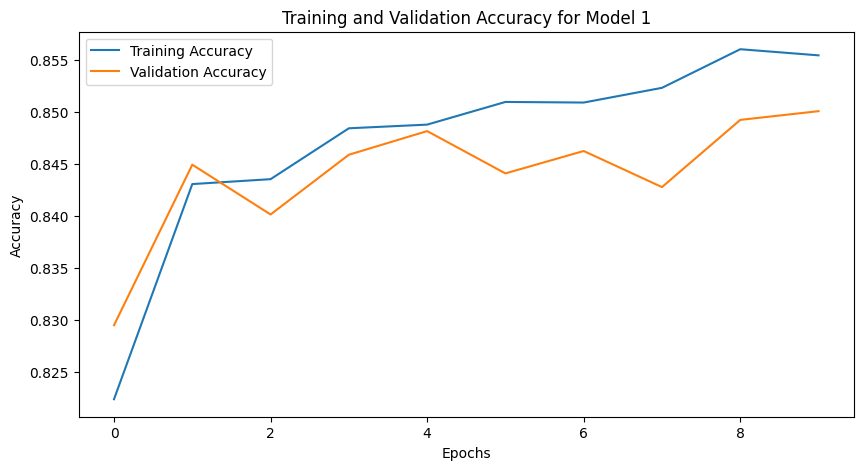

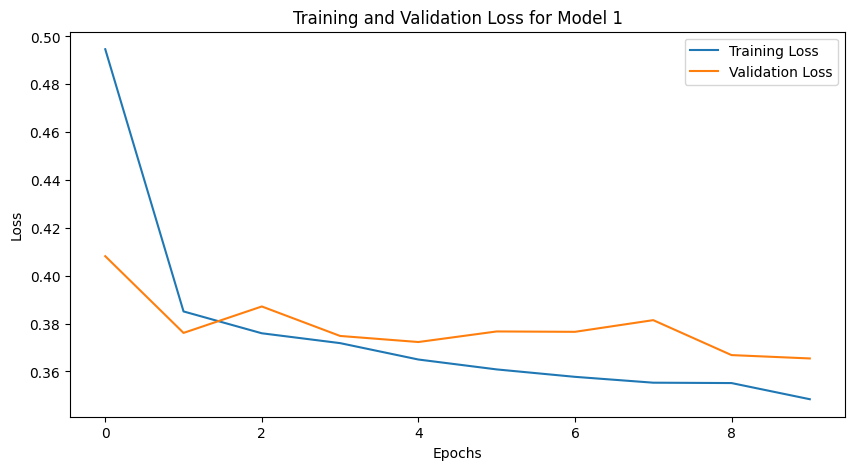

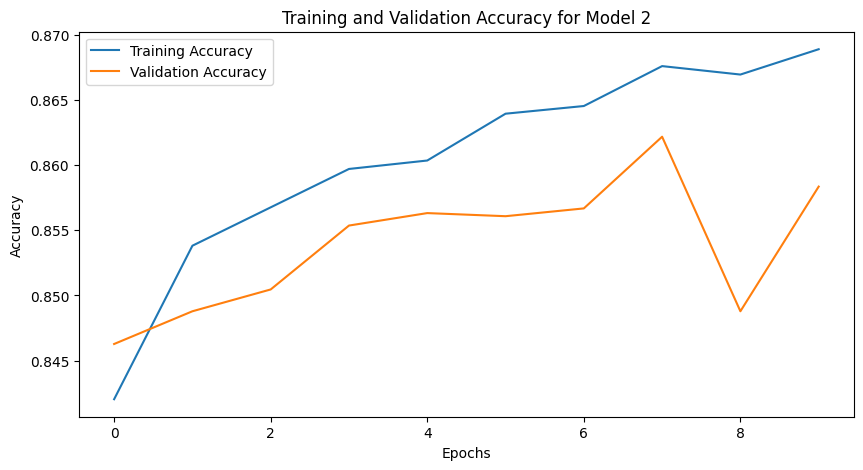

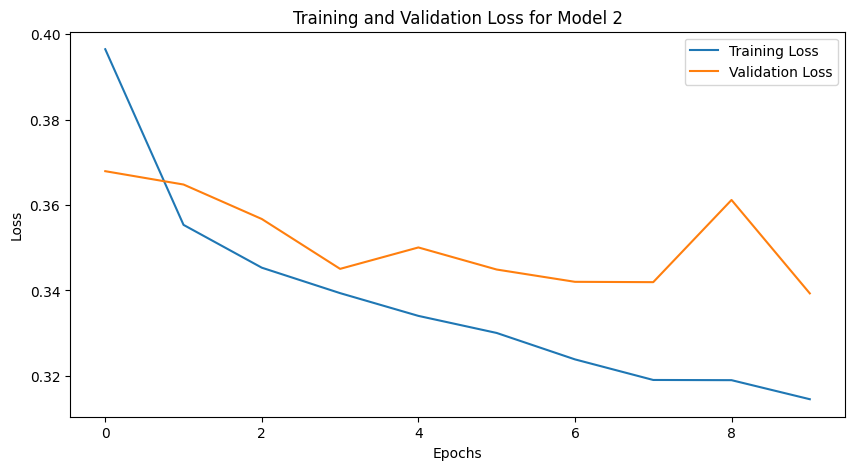

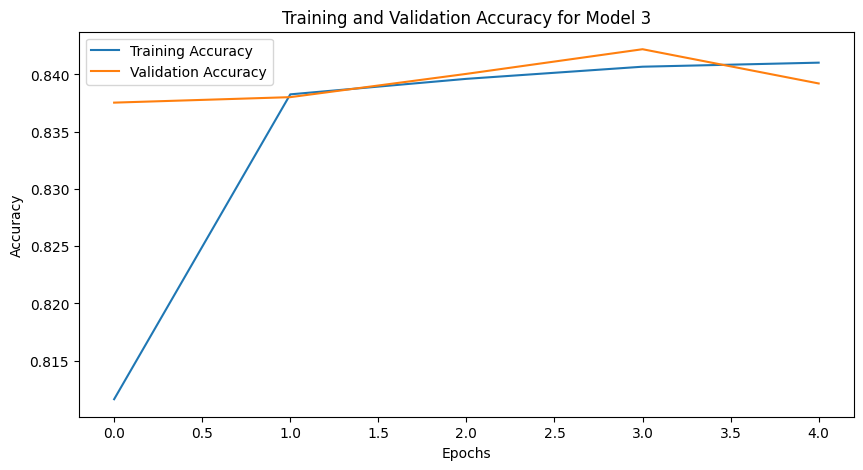

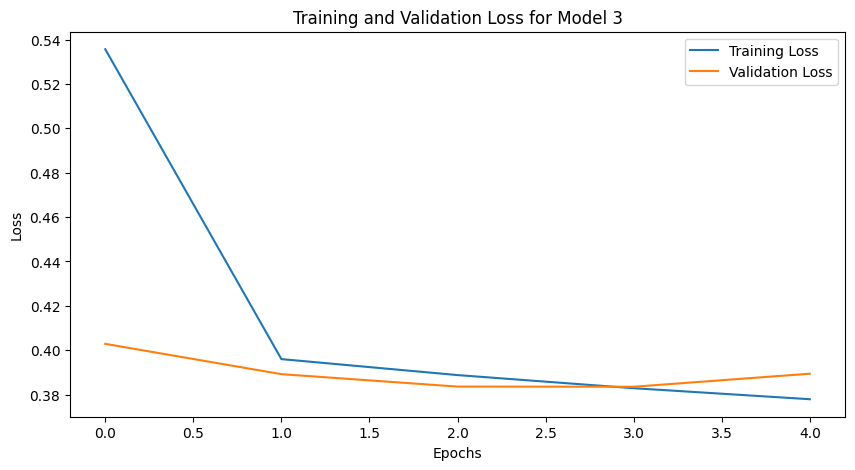

In [33]:
histories = [history1, history2, history3]

labels = ['Model 1', 'Model 2', 'Model 3']

for i, history in enumerate(histories):

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {labels[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {labels[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [31]:
# List of pre-trained models
model_1 = load_model('vgg_model.keras')
model_2 = load_model('resnet_model.keras')
model_3 = load_model('densenet_model.keras')

model_1 = Model(inputs=model1.input, outputs=model1.output, name="VGG")
model_2 = Model(inputs=model2.input, outputs=model2.output, name="ResNet")
model_3 = Model(inputs=model3.input, outputs=model3.output, name="DenseNet")

models = [model_1, model_2, model_3]
input_layer = Input(shape=(224, 224, 3))
outputs = [model(input_layer) for model in models]
ensemble_output = Average()(outputs)
ensemble_output = Dense(2, activation='softmax')(ensemble_output)

ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/ensemble.h5',
    monitor='val_accuracy',
    save_best_only=True,
)

ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

def preprocess_labels(image, label):
    return image, tensorflow.one_hot(label, depth=2)

ensemble_train_ds = train_ds.map(preprocess_labels)
ensemble_val_ds = val_ds.map(preprocess_labels)

ensemble_model.fit(
    ensemble_train_ds,
    epochs=5,
    validation_data=ensemble_val_ds,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 325s 530ms/step - accuracy: 0.8197 - loss: 0.4925 - val_accuracy: 0.8195 - val_loss: 0.4722
Epoch 2/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 241s 454ms/step - accuracy: 0.8197 - loss: 0.4719 - val_accuracy: 0.8195 - val_loss: 0.4722
Epoch 3/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 236s 444ms/step - accuracy: 0.8197 - loss: 0.4719 - val_accuracy: 0.8195 - val_loss: 0.4722
Epoch 4/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 240s 451ms/step - accuracy: 0.8197 - loss: 0.4719 - val_accuracy: 0.8195 - val_loss: 0.4722
Epoch 5/5
531/531 ━━━━━━━━━━━━━━━━━━━━ 240s 452ms/step - accuracy: 0.8197 - loss: 0.4719 - val_accuracy: 0.8195 - val_loss: 0.4722


In [39]:
ensemble_model.save('ensemble.h5')

In [32]:
ensemble_test_ds = test_ds.map(preprocess_labels)

loss, acc = ensemble_model.evaluate(ensemble_test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

262/262 ━━━━━━━━━━━━━━━━━━━━ 43s 165ms/step - accuracy: 0.8209 - loss: 0.4701
Test Loss: 0.4722048342227936
Test Accuracy: 0.8194760084152222


In [ ]:
model_vgg = load_model('vgg_model.h5')
model_resnet = load_model('resnet_model.h5')
model_densenet = load_model('densenet_model.h5')
model4 = load_model('ensemble.h5')

def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

def predict_single_model(image, model):
    if image is None:
        return "Please provide an image."
    processed_image = preprocess_image(image)
    input_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(input_image)
    class_index = np.argmax(prediction)
    class_labels = ['Benign', 'Malignant']
    predicted_class = class_labels[class_index]
    confidence = prediction[0][class_index]
    return f"{predicted_class} (Confidence: {confidence:.2f})"

def predict_vgg(image):
    return predict_single_model(image, model_vgg)

def predict_resnet(image):
    return predict_single_model(image, model_resnet)

def predict_densenet(image):
    return predict_single_model(image, model_densenet)

def predict_ensemble(image):
    return predict_single_model(image, model4)

with gr.Blocks(title="Skin Lesion Classifier") as demo:
    gr.Markdown("# Skin Lesion Classifier")
    gr.Markdown("Upload images of skin lesions to classify them as benign or malignant using different models.")

    with gr.Row():
        vgg_input = gr.Image(type="numpy", label="VGG16 Input")
        resnet_input = gr.Image(type="numpy", label="ResNet50 Input")
        densenet_input = gr.Image(type="numpy", label="DenseNet201 Input")
        ensemble_input = gr.Image(type="numpy", label="Ensemble Input")

    with gr.Row():
        vgg_output = gr.Textbox(label="VGG16 Prediction")
        resnet_output = gr.Textbox(label="ResNet50 Prediction")
        densenet_output = gr.Textbox(label="DenseNet201 Prediction")
        ensemble_output = gr.Textbox(label="Ensemble Prediction")


    vgg_button = gr.Button("Predict with VGG16")
    resnet_button = gr.Button("Predict with ResNet50")
    densenet_button = gr.Button("Predict with DenseNet201")
    ensemble_button = gr.Button("Predict with Ensemble")


    vgg_button.click(predict_vgg, inputs=vgg_input, outputs=vgg_output)
    resnet_button.click(predict_resnet, inputs=resnet_input, outputs=resnet_output)
    densenet_button.click(predict_densenet, inputs=densenet_input, outputs=densenet_output)
    ensemble_button.click(predict_ensemble, inputs=ensemble_input, outputs=ensemble_output)

demo.launch()